## <span style="color:teal">Partie 0 - Les librairies </span>

In [45]:
# On vérifie qu'on a bien une distribution Python ≥3.8
import sys
assert sys.version_info >= (3, 8)

# Les classiques
import numpy as np
import pandas as pd

# Pour tracer de jolis graphes
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
from pandas.plotting import scatter_matrix

# On vérifie qu'on a bien une distribution Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# données
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# algorithmes
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE
# metriques
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_auc_score

In [46]:
# Pour tracer de jolis graphes
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
from pandas.plotting import scatter_matrix

In [47]:
# Etude des graphes et réseaux
import networkx as nx

# Algorithme Apriori
from mlxtend.preprocessing import TransactionEncoder # encode database transaction data in form of a Python list of lists into a NumPy array.
from mlxtend.frequent_patterns import apriori,association_rules

## <span style="color:teal">Partie 1 - Les données </span>

### Charger les données

Les données sont chargées dans un Database pour qu'on puisse utiliser panda dans la suite.

In [48]:
# On charge le dataset dans un DataFrame nommé dfTotal
dfTotal = pd.read_excel('data/BDTotal-Test.xlsx')

In [49]:
# Vérifier l'absence de valeurs manquantes
dfTotal.isnull().sum()

Unnamed: 0                                      0
Longitude_ville_habitation                    140
Latitude_ville_habitation                     140
Genre                                           0
Boursier                                        0
                                             ... 
Formation_Telecom_sainté_data                1350
Formation_Telecom_sainté_image_photonique    1345
Formation_ET0215_1                            837
Formation_ET0215_2                            837
Distance_Albi_km                              140
Length: 310, dtype: int64

In [50]:
# Stats de base maintenant qu'on a un DF mieux ficelé (bon, il ne faut pas s'attendre à grand chose pour être honnête)
cm = sns.color_palette("blend:white,blue",as_cmap= True)
dfTotal.describe().style.background_gradient(cmap= cm,axis = None)

,Unnamed: 0,Longitude_ville_habitation,Latitude_ville_habitation,Genre,bac_moyenne_générale,bac_moyenne_maths,Moyenne_Physique_Bac,Moyenne_Francais_Bac,Moyenne_Anglais_Bac,Absenteisme_Bac,Probleme_discipline_Bac,Aide_Ecole_Pour_entreprise,Experience_entreprise_1,Experience_entreprise_2,Experience_entreprise_3,Etudiant_or_not_annee_N,Diplome_obtenu_annee_N,Moyenne_Generale_S1_annee_N,Moyenne_Generale_S2_annee_N,Classement_Classe_S2_annee_N,Moyenne_Matiere_1_S1_annee_N,Moyenne_Matiere_2_S1_annee_N,Moyenne_Matiere_1_S2_annee_N,Moyenne_Matiere_2_S2_annee_N,Etudiant_or_not_annee_N-1,Diplome_obtenu_annee_N-1,Moyenne_Generale_S1_annee_N-1,Moyenne_Generale_S2_annee_N-1,Moyenne_Matiere_1_S1_annee_N-1,Moyenne_Matiere_2_S1_annee_N-1,Moyenne_Matiere_1_S2_annee_N-1,Moyenne_Matiere_2_S2_annee_N-1,Etudiant_or_not_annee_N-2,Diplome_obtenu_annee_N-2,Moyenne_Generale_S1_annee_N-2,Moyenne_Generale_S2_annee_N-2,Moyenne_Matiere_1_S1_annee_N-2,Moyenne_Matiere_2_S1_annee_N-2,Moyenne_Matiere_1_S2_annee_N-2,Moyenne_Matiere_2_S2_annee_N-2,Departement_annee_N-3,Etudiant_or_not_annee_N-3,Diplome_obtenu_annee_N-3,Moyenne_Generale_S1_annee_N-3,Moyenne_Generale_S2_annee_N-3,Moyenne_Matiere_1_S1_annee_N-3,Moyenne_Matiere_2_S1_annee_N-3,Moyenne_Matiere_1_S2_annee_N-3,Moyenne_Matiere_2_S2_annee_N-3,Departement_annee_N-4,Etudiant_or_not_annee_N-4,Diplome_obtenu_annee_N-4,Moyenne_Generale_S1_annee_N-4,Moyenne_Generale_S2_annee_N-4,Moyenne_Matiere_1_S1_annee_N-4,Moyenne_Matiere_2_S1_annee_N-4,Moyenne_Matiere_1_S2_annee_N-4,Moyenne_Matiere_2_S2_annee_N-4,Departement_annee_N-5,Etudiant_or_not_annee_N-5,Diplome_obtenu_annee_N-5,Moyenne_Generale_S1_annee_N-5,Moyenne_Generale_S2_annee_N-5,Moyenne_Matiere_1_S1_annee_N-5,Moyenne_Matiere_2_S1_annee_N-5,Moyenne_Matiere_1_S2_annee_N-5,Moyenne_Matiere_2_S2_annee_N-5,Contact_Etablissement,Contact_forum_virtuel_imt,Contact_salon,Contact_autre_evenement,Contact_moteur_de_recherche,Contact_page_web_apprentissage_IMT,Contact_Site_Internet_dune_ecole_IMT,Contact_site_internet_IMT,Contact_reseaux_sociaux,Contact_autre_site_internet,Contact_par_apprenti_de_lecole,Contact_par_enseignant_de_lecole,Contact_par_ami_parent,Contact_par_professionel,Contact_conseiller_dorientation,Contact_affichage_etablissement,Contact_Magazine,Contact_Autre,Referent_academique_1,Ref_Candidat_Moyenne_Annee_Precedente_S1_1,Ref_Candidat_Moyenne_Annee_Precedente_S2_1,Ref_Candidat_Moyenne_Annee_en_cours_S1_1,Ref_Candidat_Moyenne_Annee_en_cours_S2_1,Ref_Promo_Moyenne_Annee_Precedente_S1_1,Ref_Promo_Moyenne_Annee_Precedente_S2_1,Ref_Promo_Moyenne_Annee_En_cours_S1_1,Ref_Promo_Moyenne_Annee_En_cours_S2_1,Referent_academique_2,Ref_Candidat_Moyenne_Annee_Precedente_S1_2,Ref_Candidat_Moyenne_Annee_Precedente_S2_2,Ref_Candidat_Moyenne_Annee_en_cours_S1_2,Ref_Candidat_Moyenne_Annee_en_cours_S2_2,Ref_Promo_Moyenne_Annee_Precedente_S1_2,Ref_Promo_Moyenne_Annee_Precedente_S2_2,Ref_Promo_Moyenne_Annee_En_cours_S1_2,Ref_Promo_Moyenne_Annee_En_cours_S2_2,Referent_academique_3,Ref_Candidat_classement_Annee_en_cours_S2_3,Ref_Candidat_Moyenne_Annee_Precedente_S1_3,Ref_Candidat_Moyenne_Annee_Precedente_S2_3,Ref_Candidat_Moyenne_Annee_en_cours_S1_3,Ref_Candidat_Moyenne_Annee_en_cours_S2_3,Ref_Promo_Moyenne_Annee_Precedente_S1_3,Ref_Promo_Moyenne_Annee_Precedente_S2_3,Ref_Promo_Moyenne_Annee_En_cours_S1_3,Ref_Promo_Moyenne_Annee_En_cours_S2_3,Referent_academique_4,Ref_Candidat_classement_Annee_Precedente_S1_4,Ref_Candidat_classement_Annee_Precedente_S2_4,Ref_Candidat_classement_Annee_en_cours_S1_4,Ref_Candidat_classement_Annee_en_cours_S2_4,Ref_Candidat_Moyenne_Annee_Precedente_S1_4,Ref_Candidat_Moyenne_Annee_Precedente_S2_4,Ref_Candidat_Moyenne_Annee_en_cours_S1_4,Ref_Candidat_Moyenne_Annee_en_cours_S2_4,Ref_Promo_Moyenne_Annee_Precedente_S1_4,Ref_Promo_Moyenne_Annee_Precedente_S2_4,Ref_Promo_Moyenne_Annee_En_cours_S1_4,Ref_Promo_Moyenne_Annee_En_cours_S2_4,Distance_Albi_km
count,1366.000000,1226.000000,1226.000000,1366.000000,1363.000000,1349.000000,1345.000000,1360.000000,13

In [51]:
cols_mines_albi=['Formation_IMT_Mines_Albi_SENMBA',
                'Formation_IMT_Mines_Albi_SIMMA',
                'Formation_IMT_Mines_Albi_SIPHASS',
                'Formation_IMT_Mines_Albi_DD_Parma_Alternant',
                'Formation_IMT_Mines_Albi_DD_Parma_Etudiant'
          ]

In [52]:
# On regarde les valeurs qu'il y a dans les colonnes pour l'IMT Mines Albi
for col in cols_mines_albi:
  values=dfTotal[col].values.astype(str)
  print(col,np.unique(values))

Formation_IMT_Mines_Albi_SENMBA ['Abandon' 'Admis' 'Admissible' 'Convoqué oraux' 'Non convoqué'
 'Non donné' 'Non retenu Jury final' 'nan' 'non']
Formation_IMT_Mines_Albi_SIMMA ['Abandon' 'Admis' 'Admissible' 'Convoqué oraux' 'Non convoqué'
 'Non donné' 'Non retenu Jury final' 'nan' 'non']
Formation_IMT_Mines_Albi_SIPHASS ['Abandon' 'Admis' 'Admissible' 'Convoqué oraux' 'Non convoqué' 'nan'
 'non']
Formation_IMT_Mines_Albi_DD_Parma_Alternant ['nan' 'non']
Formation_IMT_Mines_Albi_DD_Parma_Etudiant ['nan' 'non']


On refait l'analyse des données classiques

In [53]:
# On récupère les infos sur les noms, types et éventuelles données manquantes de chaque feature
dfTotal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1366 entries, 0 to 1365
Columns: 310 entries, Unnamed: 0 to Distance_Albi_km
dtypes: bool(6), float64(125), int64(2), object(177)
memory usage: 3.2+ MB


## <span style="color:teal">Partie 2 - Analyse Exploratoire des Données</span>

Regardons la distribution des données pour chaque feature.

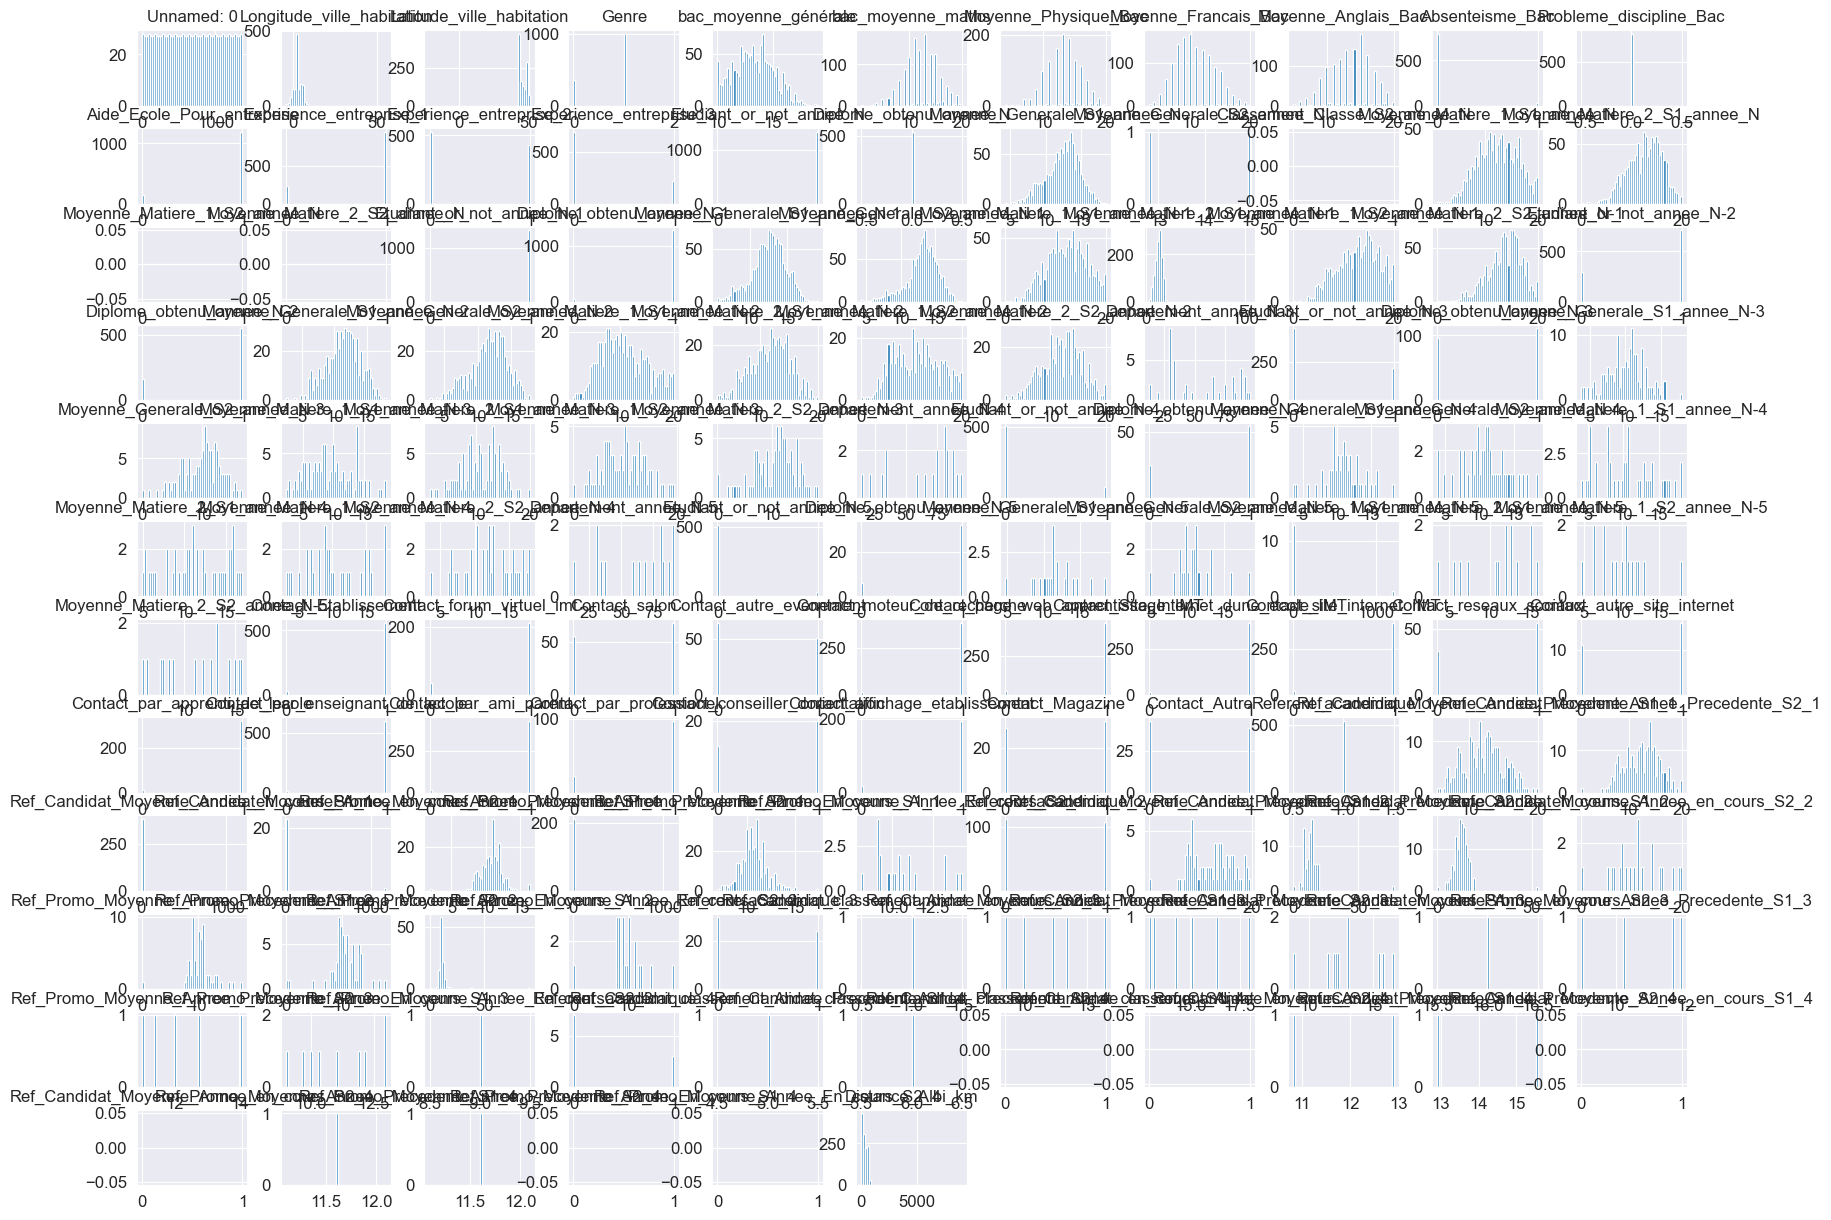

In [54]:
dfTotal.hist(bins=50, figsize=(20,15))
plt.show()

On remarque des données continues qu'on va devoir normaliser. Beaucoup de colonnes sont vides ce qui va devoir être traité par la suite.

## <span style="color:teal"> Partie 3 - Préparation des données</span>

### Préparation du jeu de données

Création de la colonne Admis_Albi avec 1 pour ceux admis dans au moyen une des options et 0 pour les autres. On vérifie qu'on a pas perdu de lignes.

In [55]:
# Créer une colonne binaire 'Admis_Albi'
dfTotal['Admis_Albi'] = dfTotal[cols_mines_albi].apply(
    lambda col: col.fillna('').str.contains('Admis', case=False)
).any(axis=1).astype(int)

# Vérifier la répartition des valeurs
print(dfTotal['Admis_Albi'].value_counts())
# Supprimer les colonnes Unnamed: car elle est pas utile et  Code_Postale_Habitation ,
# Latitude_ville_habitation, Longitude_ville_habitation car j'ai préféré garder la distance d'albi qui me parrait plus cohérent
# Pour les autres formations je ne souhaite pas les garder car je m'occupe que des admis à Albi
dfTotal = dfTotal.drop(columns=['Code_Postale_Habitation','Unnamed: 0','Latitude_ville_habitation','Longitude_ville_habitation','Formation_IMT_Atlantique_Informatique_Reseaux_Telecoms',
       'Formation_IMT_Atlantique_Logicielle',
       'Formation_IMT_Atlantique_Transformation_Digitale_Systemes_Industriels',
       'Formation_IMT_Lille_Douai_Genie_Civil_Systeme_Ferroviaires',
       'Formation_IMT_Lille_Douai_Genie_Energetique',
       'Formation_IMT_Lille_Douai_Genie_Industriel',
       'Formation_IMT_Lille_Douai_Plasturgie_Materiaux_Composites',
       'Formation_IMT_Lille_Douai_Telecom_Info',
       'Formation_IMT_Mines_Ales_Batiment',
       'Formation_IMT_Mines_Ales_Informatique_Reseaux_parcours_sys_res',
       'Formation_IMT_Mines_Ales_Mecatronique',
       'Formation_Mines_Saint_Etienne_Systeme_Electronique',
       'Formation_Telecom_Sud_Paris_Reseaux',
       'Formation_Telecom_Paris_Cybersecurite',
       'Formation_Telecom_Paris_Telecom_IoT',
       'Formation_Telecom_Paris_Systemes_Embarques',
       'Formation_Mines_Nancy_Genie_Mecanique',
       'Formation_Mines_ParisTech_Energetique',
       'Formation_ENSSAT_Informatique_Multimedia_Reseaux',
       'Formation_SIGMA_Mecanique_Genie_Industriel',
       'Formation_Telecom_Physique_Strasbourg_Electronique_Informatique_Industrielle',
       'Formation_ET0215_1', 'Formation_ET0215_2'])

Admis_Albi
0    1237
1     129
Name: count, dtype: int64


Je vais transformer tout les colonnes qui correspondent à des notes en 1 pour les notes égales ou supérieur à 14 et 0 pour le reste.

In [56]:
# Transformer la colonne de la liste en 1 pour les notes "bonnes" => 14
colonnes_a_transformer = [
    'bac_moyenne_générale',
    'bac_moyenne_maths',
    'Moyenne_Physique_Bac',
    'Moyenne_Francais_Bac',
    'Moyenne_Generale_S1_annee_N',
    'Moyenne_Generale_S2_annee_N',
    'Moyenne_Anglais_Bac',
    'Moyenne_Matiere_1_S1_annee_N',
    'Moyenne_Matiere_2_S1_annee_N',
    'Moyenne_Matiere_1_S2_annee_N',
    'Moyenne_Matiere_2_S2_annee_N',
    'Moyenne_Generale_S1_annee_N-1',
    'Moyenne_Generale_S2_annee_N-1',
    'Moyenne_Matiere_1_S1_annee_N-1',
    'Moyenne_Matiere_2_S1_annee_N-1',
    'Moyenne_Matiere_1_S2_annee_N-1',
    'Moyenne_Matiere_2_S2_annee_N-1',
    'Moyenne_Generale_S1_annee_N-2',
    'Moyenne_Generale_S2_annee_N-2',
    'Moyenne_Matiere_1_S1_annee_N-2',
    'Moyenne_Matiere_2_S1_annee_N-2',
    'Moyenne_Matiere_1_S2_annee_N-2',
    'Moyenne_Matiere_2_S2_annee_N-2',
    'Moyenne_Generale_S1_annee_N-3',
    'Moyenne_Generale_S2_annee_N-3',
    'Moyenne_Matiere_1_S1_annee_N-3',
    'Moyenne_Matiere_2_S1_annee_N-3',
    'Moyenne_Matiere_1_S2_annee_N-3',
    'Moyenne_Matiere_2_S2_annee_N-3',
    'Moyenne_Generale_S1_annee_N-4',
    'Moyenne_Generale_S2_annee_N-4',
    'Moyenne_Matiere_1_S1_annee_N-4',
    'Moyenne_Matiere_2_S1_annee_N-4',
    'Moyenne_Matiere_1_S2_annee_N-4',
    'Moyenne_Matiere_2_S2_annee_N-4',
    'Moyenne_Generale_S1_annee_N-5',
    'Moyenne_Generale_S2_annee_N-5',
    'Moyenne_Matiere_1_S1_annee_N-5',
    'Moyenne_Matiere_2_S1_annee_N-5',
    'Moyenne_Matiere_1_S2_annee_N-5',
    'Moyenne_Matiere_2_S2_annee_N-5'
]
# Appliquer la transformation pour chaque colonne
for colonne in colonnes_a_transformer:
    if colonne in dfTotal.columns:
        dfTotal[colonne] = (dfTotal[colonne] >= 14).astype(int)

Pour ce qui est des classements j'ai décidé de mettre 1 pour les classements où l'élève est dans le top 25% et 0 dans l'autre cas

In [57]:
# Fonction pour transformer le classement
def transformer_classement(valeur):
    try:
        # Séparer le numérateur et le dénominateur
        num, denom = map(int, valeur.split('/'))
        # Calculer le seuil 25% du dénominateur
        seuil = denom * 0.25
        # Retourner 1 si numérateur <= seuil, sinon 0
        return 1 if num <= seuil else 0
    except:
        # Si la valeur n'est pas valide, retourner NaN ou 0
        return 0

# Liste des colonnes de classement à transformer
colonnes_classement = [
    'Classement_Classe_S1_annee_N',
    'Classement_Classe_S2_annee_N',
    'Classement_Classe_S1_annee_N-1',
    'Classement_Classe_S2_annee_N-1',
    'Classement_Classe_S2_annee_N-2',
    'Classement_Classe_S2_annee_N-2',
    'Classement_Classe_S2_annee_N-3',
    'Classement_Classe_S2_annee_N-3',
    'Classement_Classe_S2_annee_N-4',
    'Classement_Classe_S2_annee_N-4',
    'Classement_Classe_S2_annee_N-5',
    'Classement_Classe_S2_annee_N-5',

]

# Appliquer la transformation pour chaque colonne
for colonne in colonnes_classement:
    if colonne in dfTotal.columns:
        dfTotal[colonne] = dfTotal[colonne].apply(transformer_classement)

Pareil pour la colonne distance d'Albi pour tous les élèves dont la distance d'habitation est inférieur à 100km je vais mettre 1 et le reste 0

In [58]:
# Transformer la colonne de la liste en 1 pour les distance d'albi  <= 150
dfTotal['Distance_Albi_km'] = (dfTotal['Distance_Albi_km'] <= 150).astype(int)

In [59]:
# On retire de la liste des features X les colonnes 'Admis_Albi' et 'Formation_IMT_Mines_Albi_SENMBA,Formation_IMT_Mines_Albi_SIMMA,Formation_IMT_Mines_Albi_SIPHASS,Formation_IMT_Mines_Albi_DD_Parma_Alternant,Formation_IMT_Mines_Albi_DD_Parma_Etudiant'
#qui représentent la cible
X = dfTotal.drop(columns=['Admis_Albi','Formation_IMT_Mines_Albi_SENMBA','Formation_IMT_Mines_Albi_SIMMA','Formation_IMT_Mines_Albi_SIPHASS','Formation_IMT_Mines_Albi_DD_Parma_Alternant','Formation_IMT_Mines_Albi_DD_Parma_Etudiant'])
y = dfTotal['Admis_Albi']

 nous supprimons les colonnes nulles et les colonnes ayant plus de 80% de données nulles

In [60]:
# Supprime les colones ayant plus de 50% de données nulles
X_cleaned=X.dropna(axis=1, thresh=0.5*len(X)).dropna(axis=0,how='all')
# Je transorme tout les booléens en valeur numérique
def convert_booleans_to_numeric(data):
    # Vérifier s'il y a des colonnes booléennes
    bool_cols = data.select_dtypes(include=['bool']).columns

    if not bool_cols.empty:
        print(f"Colonnes booléennes détectées : {bool_cols.tolist()}")
        # Convertir les booléens en entiers (0/1)
        data[bool_cols] = data[bool_cols].astype(int)
    else:
        print("Aucune colonne booléenne détectée.")

    return data


# Utilisation de la fonction
X_cleaned = convert_booleans_to_numeric(X_cleaned)

# Vérification des résultats
print("Transformation terminée. Aperçu des données transformées :")
print(X_cleaned.head())

Colonnes booléennes détectées : ['Boursier', 'Tiers_Temps', 'Dossier_Non_Valide_pour_apprentissage', 'bac_francais', 'Entreprise_Trouve', 'Stage_a_letranger']
Transformation terminée. Aperçu des données transformées :
   Genre  Boursier  Tiers_Temps  Dossier_Non_Valide_pour_apprentissage  \
0      1         1            0                                      0   
1      0         0            0                                      0   
2      1         0            0                                      0   
3      1         0            0                                      0   
4      1         0            0                                      0   

  Etat_dossier_inscription                       Nom_dernier_Diplome_fait  \
0                   Valide       DUT Génie mécanique et productique (GMP)   
1                   Valide                                  Autre diplôme   
2                   Valide       DUT Génie mécanique et productique (GMP)   
3                   Valide   

Faire en sorte que toutes les colonnes soient non nulles. Pour cela on va déja repérer tout les colonnes dites catégoriques. Colonnes de type objects et colonnes avec moins de 20 valeurs uniques.

In [61]:
# Afficher les types des colonnes dans X
print(X_cleaned.dtypes.value_counts())

# Identifier les colonnes catégoriques
categorical_columns = X_cleaned.select_dtypes(include=['object']).columns
print("Colonnes catégoriques : ", categorical_columns)

# Vérifier si les colonnes catégoriques contiennent des données
print(X_cleaned[categorical_columns].isnull().sum())
# Vérification des colonnes catégoriques détectées
categorical_columns = X_cleaned.select_dtypes(include=['object']).columns
print(f"Colonnes catégoriques initiales : {categorical_columns.tolist()}")

int32      48
object     36
float64    11
int64       9
Name: count, dtype: int64
Colonnes catégoriques :  Index(['Etat_dossier_inscription', 'Nom_dernier_Diplome_fait', 'bac_option',
       'bac_mention', 'bac_académie', 'Avis_poursuite_etude',
       'Type_Entreprise_Souhaitée', 'Nom_langue_1', 'Niveau_langue_1',
       'Ville_annee_N', 'Etablissement_annee_N', 'Annee_inscritpion_N',
       'Annee_detude_annee_N', 'Nom_filliere_annee_N',
       'Statut_formation_annee_N', 'Matiere_1_S1_annee_N',
       'Matiere_2_S1_annee_N', 'Matiere_1_S2_annee_N', 'Matiere_2_S2_annee_N',
       'Ville_annee_N-1', 'Etablissement_annee_N-1', 'Annee_inscritpion_N-1',
       'Annee_detude_annee_N-1', 'Nom_filliere_annee_N-1',
       'Statut_formation_annee_N-1', 'Matiere_1_S1_annee_N-1',
       'Matiere_2_S1_annee_N-1', 'Matiere_1_S2_annee_N-1',
       'Matiere_2_S2_annee_N-1', 'Etablissement_annee_N-2',
       'Annee_inscritpion_N-2', 'Annee_detude_annee_N-2',
       'Nom_filliere_annee_N-2', 'Statut_

In [62]:
# Identifier les colonnes mal classées comme numériques
potential_categorical = []

for col in X_cleaned.columns:
    try:
        # Vérifier si la colonne est numérique et a peu de valeurs uniques
        if X_cleaned[col].dtypes in [ 'float64','int64'] and X_cleaned[col].nunique() < 20:
            potential_categorical.append(col)
    except Exception as e:
        print(f"Erreur lors du traitement de la colonne {col}: {e}")

print(f"Colonnes potentiellement catégoriques : {potential_categorical}")

# Convertir les colonnes détectées en 'object' pour les traiter comme catégoriques
for col in potential_categorical:
    X_cleaned[col] = X_cleaned[col].astype('object')

#  Vérifier à nouveau les colonnes catégoriques
categorical_columns = X_cleaned.select_dtypes(include=['object']).columns
print(f"Colonnes catégoriques après conversion : {categorical_columns.tolist()}")

Colonnes potentiellement catégoriques : ['Genre', 'Absenteisme_Bac', 'Probleme_discipline_Bac', 'Aide_Ecole_Pour_entreprise', 'Experience_entreprise_1', 'Experience_entreprise_2', 'Experience_entreprise_3', 'Etudiant_or_not_annee_N', 'Classement_Classe_S1_annee_N', 'Classement_Classe_S2_annee_N', 'Etudiant_or_not_annee_N-1', 'Diplome_obtenu_annee_N-1', 'Classement_Classe_S1_annee_N-1', 'Classement_Classe_S2_annee_N-1', 'Etudiant_or_not_annee_N-2', 'Diplome_obtenu_annee_N-2', 'Classement_Classe_S2_annee_N-2', 'Classement_Classe_S2_annee_N-3', 'Classement_Classe_S2_annee_N-4', 'Classement_Classe_S2_annee_N-5']
Colonnes catégoriques après conversion : ['Genre', 'Etat_dossier_inscription', 'Nom_dernier_Diplome_fait', 'bac_option', 'bac_mention', 'bac_académie', 'Absenteisme_Bac', 'Probleme_discipline_Bac', 'Avis_poursuite_etude', 'Aide_Ecole_Pour_entreprise', 'Type_Entreprise_Souhaitée', 'Nom_langue_1', 'Niveau_langue_1', 'Experience_entreprise_1', 'Experience_entreprise_2', 'Experience_en

Après avoir fait la séparation entre colonnes numériques et colonnes catégoriques on va imputer les valeurs manquantes. En séparant bien l'imputation pour les colonnes catégoriques celles numériques


In [63]:
def impute_missing_values(data):
    # Initialiser les imputateurs
    imputer_num = SimpleImputer(strategy='mean')  # Moyenne pour les colonnes numériques
    imputer_cat = SimpleImputer(strategy='most_frequent')  # Mode pour les colonnes catégoriques

    # Identifier les colonnes numériques et catégoriques
    numeric_cols = X_cleaned.select_dtypes(include=['float64','int64']).columns
    categorical_cols = X_cleaned.select_dtypes(include=['object']).columns

    # Imputer les valeurs manquantes
    data_imputed = data.copy()  # Créer une copie pour conserver l'original
    if not numeric_cols.empty:
        data_imputed[numeric_cols] = imputer_num.fit_transform(data[numeric_cols])
    if not categorical_cols.empty:
        data_imputed[categorical_cols] = imputer_cat.fit_transform(data[categorical_cols])

    return data_imputed


# Utilisation de la fonction sur un DataFrame X_cleaned
X_cleaned = impute_missing_values(X_cleaned)

# Vérification des résultats
print("Imputation terminée. Aperçu des données nettoyées :")
print(X_cleaned.head())

Imputation terminée. Aperçu des données nettoyées :
  Genre  Boursier  Tiers_Temps  Dossier_Non_Valide_pour_apprentissage  \
0     1         1            0                                      0   
1     0         0            0                                      0   
2     1         0            0                                      0   
3     1         0            0                                      0   
4     1         0            0                                      0   

  Etat_dossier_inscription                       Nom_dernier_Diplome_fait  \
0                   Valide       DUT Génie mécanique et productique (GMP)   
1                   Valide                                  Autre diplôme   
2                   Valide       DUT Génie mécanique et productique (GMP)   
3                   Valide       DUT Génie mécanique et productique (GMP)   
4                   Valide  DUT Génie chimique, génie des procédés (GCGP)   

   bac_francais       bac_option   bac_mention

On passe au découpage du jeu de données

In [64]:
# Diviser les données et on vérifie qu'on a perdu aucun élève
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)
len(X_train)+ len(X_test)

1366

In [65]:
X_train.head()

,Genre,Boursier,Tiers_Temps,Dossier_Non_Valide_pour_apprentissage,Etat_dossier_inscription,Nom_dernier_Diplome_fait,bac_francais,bac_option,bac_mention,bac_académie,...,Moyenne_Matiere_2_S2_annee_N-4,Moyenne_Generale_S1_annee_N-5,Moyenne_Generale_S2_annee_N-5,Classement_Classe_S2_annee_N-5,Moyenne_Matiere_1_S1_annee_N-5,Moyenne_Matiere_2_S1_annee_N-5,Moyenne_Matiere_1_S2_annee_N-5,Moyenne_Matiere_2_S2_annee_N-5,Referent_etat_1,Distance_Albi_km
1232,1,0,1,0,Valide,CPGE Spé ATS ingénierie industrielle,1,Bac S,Sans mention,Grenoble,...,0,0,0,0,0,0,0,0,Soumis,0
1295,1,0,0,0,Valide,BUT SGM - Métiers de la caractérisation et de ...,1,Bac S,Assez Bien,Orléans-Tours,...,0,0,0,0,0,0,0,0,Soumis,0
1248,1,0,1,0,Valide,BTS Aéronautique,1,Bac S,Très bien,Toulouse,...,0,0,0,0,0,0,0,0,Soumis,1
861,1,0,0,0,Valide,CPGE Spé ATS ingénierie industrielle,1,Bac Techno STI2D,Assez Bien,Académie de Versailles,...,1,0,0,0,0,0,0,0,Soumis,0
54,1,1,0,0,Valide,Licence,1,Bac S,Assez Bien,Académie de Rennes,...,0,0,0,0,0,0,0,0,Soumis,0


In [66]:
X_test.head()

,Genre,Boursier,Tiers_Temps,Dossier_Non_Valide_pour_apprentissage,Etat_dossier_inscription,Nom_dernier_Diplome_fait,bac_francais,bac_option,bac_mention,bac_académie,...,Moyenne_Matiere_2_S2_annee_N-4,Moyenne_Generale_S1_annee_N-5,Moyenne_Generale_S2_annee_N-5,Classement_Classe_S2_annee_N-5,Moyenne_Matiere_1_S1_annee_N-5,Moyenne_Matiere_2_S1_annee_N-5,Moyenne_Matiere_1_S2_annee_N-5,Moyenne_Matiere_2_S2_annee_N-5,Referent_etat_1,Distance_Albi_km
1270,1,0,0,0,Valide,CPGE Spé ATS ingénierie industrielle,1,Bac S,Sans mention,Toulouse,...,0,0,0,0,0,0,0,0,En attente,1
932,1,1,0,0,Valide,DUT Génie industriel et maintenance (GIM),1,Bac S,Sans mention,Académie de Toulouse,...,0,0,0,0,0,0,0,0,Soumis,1
277,1,0,0,0,Valide,"DUT Génie chimique, génie des procédés (GCGP)",1,Bac S,Assez Bien,Académie de Toulouse,...,0,0,0,0,0,0,0,0,Soumis,1
910,1,0,0,0,Valide,Autre Formation (non listée ci-dessous),1,Bac S,Bien,Académie de Lyon,...,0,0,0,0,0,0,0,0,Soumis,0
934,0,0,0,0,Valide,DUT Chimie,1,Bac S,Bien,Académie de Montpellier,...,0,0,0,0,0,0,0,0,Soumise,1


In [67]:
y_train.head()

1232    0
1295    0
1248    0
861     0
54      0
Name: Admis_Albi, dtype: int32

In [68]:
y_test.head()

1270    0
932     0
277     0
910     0
934     0
Name: Admis_Albi, dtype: int32

Normalisation

In [69]:
# Séparer les colonnes numériques et catégoriques
num_cols = X_cleaned.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X_cleaned.select_dtypes(include=['object']).columns

In [70]:
len(num_cols)

0

J'ai remarqué qu'en faisant les changements précédents je n'avais plus de valeurs numériques

In [71]:
# Normalisation des variables numériques StandardScaler pour standardisation (moyenne 0, écart-type 1) régression linéaire ou les forêts aléatoires (SVM, KNN).
#scaler = StandardScaler()
#X_train_num = pd.DataFrame(scaler.fit_transform(X_train[num_cols]), columns=num_cols)
#X_test_num = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)

In [72]:
def one_hot_encode(data, categorical_columns):
    # Vérification si les colonnes catégoriques sont présentes
    categorical_columns = [col for col in categorical_columns if col in data.columns]

    # Initialisation de l'encodeur One-Hot
    one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

    # Appliquer One-Hot Encoding
    one_hot_encoded = one_hot_encoder.fit_transform(data[categorical_columns])
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_columns))

    # Réinitialisation explicite des index
    one_hot_encoded_df.reset_index(drop=True, inplace=True)

    # Supprimer les colonnes catégoriques d'origine et ajouter les colonnes encodées
    data_encoded = pd.concat([data.drop(columns=categorical_columns).reset_index(drop=True), one_hot_encoded_df], axis=1)

    return data_encoded, one_hot_encoder

def transform_test_data(test_data, categorical_columns, one_hot_encoder):
    # Vérification si les colonnes catégoriques sont présentes
    categorical_columns = [col for col in categorical_columns if col in test_data.columns]

    # Appliquer One-Hot Encoding
    one_hot_encoded = one_hot_encoder.transform(test_data[categorical_columns])
    one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_columns))

    # Réinitialisation explicite des index
    one_hot_encoded_df.reset_index(drop=True, inplace=True)

    # Supprimer les colonnes catégoriques d'origine et ajouter les colonnes encodées
    test_data_encoded = pd.concat([test_data.drop(columns=categorical_columns).reset_index(drop=True), one_hot_encoded_df], axis=1)

    return test_data_encoded

# Appliquer One-Hot Encoding sur X_train et transformer X_test avec le même encodeur
print("Encodage du jeu d'entraînement en cours...")
X_train_cat, ohe = one_hot_encode(X_train, cat_cols)

print("Transformation du jeu de test en cours...")
X_test_cat = transform_test_data(X_test, cat_cols, ohe)

# Vérification
print("Encodage terminé. Aperçu des données encodées :")
print("X_train encodé :")
print(X_train_cat.head())
print("X_test encodé :")
print(X_test_cat.head())

Encodage du jeu d'entraînement en cours...
Transformation du jeu de test en cours...
Encodage terminé. Aperçu des données encodées :
X_train encodé :
   Boursier  Tiers_Temps  Dossier_Non_Valide_pour_apprentissage  bac_francais  \
0         0            1                                      0             1   
1         0            0                                      0             1   
2         0            1                                      0             1   
3         0            0                                      0             1   
4         1            0                                      0             1   

   bac_moyenne_générale  bac_moyenne_maths  Moyenne_Physique_Bac  \
0                     0                  0                     0   
1                     0                  0                     0   
2                     1                  1                     1   
3                     0                  0                     0   
4                     0

C:\Users\oussama\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2, 5, 16, 17, 20, 21, 29, 30, 34, 40, 43, 46, 47] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [73]:
# Combiner les colonnes numériques et catégoriques
# La concaténation n'a plus lieu d'être vu que je n'ai plus de données numériques
# Je la laisse quand même pour être assez large dans l'étude du cas
X_train_num=X_train_cat
X_test_num=X_test_cat
X_train_processed = pd.concat([X_train_num, X_train_cat], axis=1)
X_test_processed = pd.concat([X_test_num, X_test_cat], axis=1)

# Vérifier les dimensions finales
print(f"X_train shape: {X_train_processed.shape}")
print(f"X_test shape: {X_test_processed.shape}")

X_train shape: (1092, 3148)
X_test shape: (274, 3148)


## <span style="color:teal"> Partie 4 - Modélisation et évaluation</span>

Nous allons pouvoir enfin entraîner des algorithmes de classification pour obtenir les caractéristiques des admis en fonction des features.

Régression logistique

SMOTE améliore la répartition des points dans l'espace des caractéristiques

In [74]:
# Grille de paramètres pour SMOTE pour les données d'entrainement
smote_params = {
    'k_neighbors': [3, 5, 7, 10],  # Nombre de voisins
    'sampling_strategy': [0.6, 0.75, 1.0],  # Ratio de sur-échantillonnage
}

# Initialisation du modèle pour évaluation des données SMOTE
log_reg_clf = LogisticRegression(class_weight='balanced')

# Fonction d'évaluation des paramètres SMOTE
def evaluate_smote_params(params, X, y):
    smote = SMOTE(k_neighbors=params['k_neighbors'], sampling_strategy=params['sampling_strategy'], random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    scores = cross_val_score(log_reg_clf, X_resampled, y_resampled, cv=3, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1)
    return scores.mean()

# Recherche manuelle des meilleurs paramètres pour SMOTE
best_score = 0
best_params = {}

for k in smote_params['k_neighbors']:
    for strategy in smote_params['sampling_strategy']:
        params = {'k_neighbors': k, 'sampling_strategy': strategy}
        score = evaluate_smote_params(params, X_train_processed, y_train)
        if score > best_score:
            best_score = score
            best_params = params

print("Meilleurs paramètres SMOTE :", best_params)

# Application de SMOTE avec les meilleurs paramètres trouvés
smote_reg_clf = SMOTE(**best_params, random_state=42)
X_resampled, y_resampled = smote_reg_clf.fit_resample(X_train_processed, y_train)

Meilleurs paramètres SMOTE : {'k_neighbors': 5, 'sampling_strategy': 1.0}


In [75]:
# Grille de paramètres pour SMOTE pour les données de test
smote_params = {
    'k_neighbors': [3, 5, 7, 10],  # Nombre de voisins
    'sampling_strategy': [0.6, 0.75, 1.0],  # Ratio de sur-échantillonnage
}

# Initialisation du modèle pour évaluation des données SMOTE
log_reg_clf = LogisticRegression(class_weight='balanced')

# Fonction d'évaluation des paramètres SMOTE
def evaluate_smote_params(params, X, y):
    smote = SMOTE(k_neighbors=params['k_neighbors'], sampling_strategy=params['sampling_strategy'], random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    scores = cross_val_score(log_reg_clf, X_resampled, y_resampled, cv=3, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1)
    return scores.mean()

# Recherche manuelle des meilleurs paramètres pour SMOTE
best_score = 0
best_params = {}

for k in smote_params['k_neighbors']:
    for strategy in smote_params['sampling_strategy']:
        params = {'k_neighbors': k, 'sampling_strategy': strategy}
        score = evaluate_smote_params(params, X_test_processed, y_test)
        if score > best_score:
            best_score = score
            best_params = params

print("Meilleurs paramètres SMOTE :", best_params)

# Application de SMOTE avec les meilleurs paramètres trouvés
smote_reg_clf_test = SMOTE(**best_params, random_state=42)
X_resampled_test, y_resampled_test = smote_reg_clf_test.fit_resample(X_test_processed, y_test)

Meilleurs paramètres SMOTE : {'k_neighbors': 5, 'sampling_strategy': 1.0}


In [76]:
# Entraînement du classificateur sur le jeu d'entraînement normalisé
# La cible n'a pas eu besoin d'être normalisée (variable discrète binaire)
log_reg_clf.fit(X_resampled, y_resampled)

C:\Users\oussama\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [77]:
# Modèle de prédiction appliqué au jeu de test/validation normalisé
y_pred_log_reg = log_reg_clf.predict(X_resampled_test)

In [78]:
# Calcul de la précision
print(accuracy_score(y_resampled, log_reg_clf.predict(X_resampled)))

log_reg_acc = accuracy_score(y_resampled_test, y_pred_log_reg)
print(log_reg_acc)

0.9636363636363636
0.6336032388663968


In [79]:
# Analyse de la performance intrinsèque du modèle
print("Matrice de confusion")
print(confusion_matrix(y_resampled_test, y_pred_log_reg))
print("---------------------------")
print("Rapport métriques de performance")
print(classification_report(y_resampled_test, y_pred_log_reg))

Matrice de confusion
[[217  30]
 [151  96]]
---------------------------
Rapport métriques de performance
              precision    recall  f1-score   support

           0       0.59      0.88      0.71       247
           1       0.76      0.39      0.51       247

    accuracy                           0.63       494
   macro avg       0.68      0.63      0.61       494
weighted avg       0.68      0.63      0.61       494



K plus proches voisins (kNN)

In [80]:
# Grille de paramètres pour SMOTE pour les données d'entrainement
smote_params = {
    'k_neighbors': [3, 5, 7, 10],  # Nombre de voisins
    'sampling_strategy': [0.6, 0.75, 1.0],  # Ratio de sur-échantillonnage
}

# Initialisation du modèle pour évaluation des données SMOTE
knn_clf = KNeighborsClassifier(weights='distance')

# Fonction d'évaluation des paramètres SMOTE
def evaluate_smote_params(params, X, y):
    smote = SMOTE(k_neighbors=params['k_neighbors'], sampling_strategy=params['sampling_strategy'], random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    scores = cross_val_score(knn_clf, X_resampled, y_resampled, cv=3, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1)
    return scores.mean()

# Recherche manuelle des meilleurs paramètres pour SMOTE
best_score = 0
best_params = {}

for k in smote_params['k_neighbors']:
    for strategy in smote_params['sampling_strategy']:
        params = {'k_neighbors': k, 'sampling_strategy': strategy}
        score = evaluate_smote_params(params, X_train_processed, y_train)
        if score > best_score:
            best_score = score
            best_params = params

print("Meilleurs paramètres SMOTE :", best_params)

# Application de SMOTE avec les meilleurs paramètres trouvés
smote_knn_clf = SMOTE(**best_params, random_state=42)
X_resampled, y_resampled = smote_knn_clf.fit_resample(X_train_processed, y_train)

Meilleurs paramètres SMOTE : {'k_neighbors': 3, 'sampling_strategy': 1.0}


In [81]:
# Grille de paramètres pour SMOTE pour les données de test
smote_params = {
    'k_neighbors': [3, 5, 7, 10],  # Nombre de voisins
    'sampling_strategy': [0.6, 0.75, 1.0],  # Ratio de sur-échantillonnage
}

# Initialisation du modèle pour évaluation des données SMOTE
knn_clf = KNeighborsClassifier(weights='distance')

# Fonction d'évaluation des paramètres SMOTE
def evaluate_smote_params(params, X, y):
    smote = SMOTE(k_neighbors=params['k_neighbors'], sampling_strategy=params['sampling_strategy'], random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    scores = cross_val_score(knn_clf, X_resampled, y_resampled, cv=3, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1)
    return scores.mean()

# Recherche manuelle des meilleurs paramètres pour SMOTE
best_score = 0
best_params = {}

for k in smote_params['k_neighbors']:
    for strategy in smote_params['sampling_strategy']:
        params = {'k_neighbors': k, 'sampling_strategy': strategy}
        score = evaluate_smote_params(params, X_test_processed, y_test)
        if score > best_score:
            best_score = score
            best_params = params

print("Meilleurs paramètres SMOTE :", best_params)

# Application de SMOTE avec les meilleurs paramètres trouvés
smote_knn_clf_test = SMOTE(**best_params, random_state=42)
X_resampled_test, y_resampled_test = smote_knn_clf_test.fit_resample(X_test_processed, y_test)

Meilleurs paramètres SMOTE : {'k_neighbors': 3, 'sampling_strategy': 0.75}


In [82]:
# Entraînement du classificateur sur le jeu d'entraînement normalisé
knn_clf.fit(X_resampled, y_resampled)

KNeighborsClassifier(weights='distance')

In [83]:
# Modèle de prédiction appliqué au jeu de test/validation normalisé
y_pred_knn = knn_clf.predict(X_resampled_test)

In [84]:
# Calcul de la précision
print(accuracy_score(y_resampled, knn_clf.predict(X_resampled)))

knn_acc = accuracy_score(y_resampled_test, y_pred_knn)
print(knn_acc)

1.0
0.5324074074074074


In [85]:
# Analyse de la performance intrinsèque du modèle
print("Matrice de confusion")
print(confusion_matrix(y_resampled_test, y_pred_knn))
print("---------------------------")
print("Rapport métriques de performance")
print(classification_report(y_resampled_test, y_pred_knn))

Matrice de confusion
[[125 122]
 [ 80 105]]
---------------------------
Rapport métriques de performance
              precision    recall  f1-score   support

           0       0.61      0.51      0.55       247
           1       0.46      0.57      0.51       185

    accuracy                           0.53       432
   macro avg       0.54      0.54      0.53       432
weighted avg       0.55      0.53      0.53       432



Séparateur à Vaste Marge (Support Vector Machine, SVM)

In [86]:
# Grille de paramètres pour SMOTE pour les données d'entrainement
smote_params = {
    'k_neighbors': [3, 5, 7, 10],  # Nombre de voisins
    'sampling_strategy': [0.6, 0.75, 1.0],  # Ratio de sur-échantillonnage
}

# Initialisation du modèle pour évaluation des données SMOTE
svc_clf = SVC(class_weight='balanced',C = 20, gamma = 0.1,kernel ='rbf')

# Fonction d'évaluation des paramètres SMOTE
def evaluate_smote_params(params, X, y):
    smote = SMOTE(k_neighbors=params['k_neighbors'], sampling_strategy=params['sampling_strategy'], random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    scores = cross_val_score(svc_clf, X_resampled, y_resampled, cv=3, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1)
    return scores.mean()

# Recherche manuelle des meilleurs paramètres pour SMOTE
best_score = 0
best_params = {}

for k in smote_params['k_neighbors']:
    for strategy in smote_params['sampling_strategy']:
        params = {'k_neighbors': k, 'sampling_strategy': strategy}
        score = evaluate_smote_params(params, X_train_processed, y_train)
        if score > best_score:
            best_score = score
            best_params = params

print("Meilleurs paramètres SMOTE :", best_params)

# Application de SMOTE avec les meilleurs paramètres trouvés
smote_svc = SMOTE(**best_params, random_state=42)
X_resampled, y_resampled = smote_svc.fit_resample(X_train_processed, y_train)

Meilleurs paramètres SMOTE : {'k_neighbors': 7, 'sampling_strategy': 1.0}


In [87]:
# Grille de paramètres pour SMOTE pour les données de test
smote_params = {
    'k_neighbors': [3, 5, 7, 10],  # Nombre de voisins
    'sampling_strategy': [0.6, 0.75, 1.0],  # Ratio de sur-échantillonnage
}

# Initialisation du modèle pour évaluation des données SMOTE
svc_clf = SVC(class_weight='balanced',C = 20, gamma = 0.1,kernel ='rbf')

# Fonction d'évaluation des paramètres SMOTE
def evaluate_smote_params(params, X, y):
    smote = SMOTE(k_neighbors=params['k_neighbors'], sampling_strategy=params['sampling_strategy'], random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    scores = cross_val_score(svc_clf, X_resampled, y_resampled, cv=3, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1)
    return scores.mean()

# Recherche manuelle des meilleurs paramètres pour SMOTE
best_score = 0
best_params = {}

for k in smote_params['k_neighbors']:
    for strategy in smote_params['sampling_strategy']:
        params = {'k_neighbors': k, 'sampling_strategy': strategy}
        score = evaluate_smote_params(params, X_test_processed, y_test)
        if score > best_score:
            best_score = score
            best_params = params

print("Meilleurs paramètres SMOTE :", best_params)

# Application de SMOTE avec les meilleurs paramètres trouvés
smote_svc_test = SMOTE(**best_params, random_state=42)
X_resampled_test, y_resampled_test = smote_svc_test.fit_resample(X_test_processed, y_test)

Meilleurs paramètres SMOTE : {'k_neighbors': 5, 'sampling_strategy': 1.0}


In [88]:
svc = SVC(class_weight='balanced')
# Grille de paramètres pour SVC
svc_params = {
    'gamma' : [ 0.01, 0.1],# Influence d'un point d'entraînement
    'C' : [ 0.1, 1,  20],  #Parametre de regularisation
    'kernel': ['linear', 'rbf'],  # Type de noyau
}


# Recherche des meilleurs paramètres avec RandomizedSearchCV
random_search_svc = RandomizedSearchCV(
    estimator=svc,
    param_distributions=svc_params,
    n_iter=5,  # Limiter à 5 combinaisons aléatoires
    scoring='f1',  # Priorisez le F1-score pour les données déséquilibrées
    cv=3,  # Réduire à 3 plis pour accélérer
    n_jobs=-1,  # Utiliser tous les cœurs disponibles
    verbose=1,
    random_state=42
)

# Ajustement du modèle avec les données sur-échantillonnées
random_search_svc.fit(X_resampled, y_resampled)

# Meilleurs paramètres pour SVC
best_svc_params = random_search_svc.best_params_
print("Meilleurs paramètres SVC :", best_svc_params)

# Utilisation du modèle avec les meilleurs paramètres
best_svc_model = random_search_svc.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Meilleurs paramètres SVC : {'kernel': 'rbf', 'gamma': 0.01, 'C': 20}


In [89]:
# Entraînement du classificateur sur le jeu d'entraînement normalisé
# Utilisation des hyperparamètres trouvés avec le GridSearch

svc_clf = SVC(class_weight='balanced',C = 20, gamma = 0.1,kernel ='rbf')
svc_clf.fit(X_resampled, y_resampled)

SVC(C=20, class_weight='balanced', gamma=0.1)

In [90]:
# Modèle de prédiction appliqué au jeu de test/validation normalisé
y_pred_svc = svc_clf.predict(X_resampled_test)

In [91]:
# Calcul de la précision
print(accuracy_score(y_resampled, svc_clf.predict(X_resampled)))

svc_acc = accuracy_score(y_resampled_test, y_pred_svc)
print(svc_acc)

1.0
0.5404858299595142


In [92]:
# Analyse de la performance intrinsèque du modèle
print("Matrice de confusion")
print(confusion_matrix(y_resampled_test, y_pred_svc))
print("---------------------------")
print("Rapport métriques de performance")
print(classification_report(y_resampled_test, y_pred_svc))

Matrice de confusion
[[246   1]
 [226  21]]
---------------------------
Rapport métriques de performance
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       247
           1       0.95      0.09      0.16       247

    accuracy                           0.54       494
   macro avg       0.74      0.54      0.42       494
weighted avg       0.74      0.54      0.42       494



Arbre de décision (Decision Tree Classifier)

In [93]:
# Grille de paramètres pour SMOTE pour les données d'entrainement
smote_params = {
    'k_neighbors': [3, 5, 7, 10],  # Nombre de voisins
    'sampling_strategy': [0.6, 0.75, 1.0],  # Ratio de sur-échantillonnage
}

# Initialisation du modèle pour évaluation des données SMOTE
dtc_clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 19, min_samples_leaf = 1, min_samples_split = 2, splitter = 'best',class_weight='balanced')

# Fonction d'évaluation des paramètres SMOTE
def evaluate_smote_params(params, X, y):
    smote = SMOTE(k_neighbors=params['k_neighbors'], sampling_strategy=params['sampling_strategy'], random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    scores = cross_val_score(dtc_clf, X_resampled, y_resampled, cv=3, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1)
    return scores.mean()

# Recherche manuelle des meilleurs paramètres pour SMOTE
best_score = 0
best_params = {}

for k in smote_params['k_neighbors']:
    for strategy in smote_params['sampling_strategy']:
        params = {'k_neighbors': k, 'sampling_strategy': strategy}
        score = evaluate_smote_params(params, X_train_processed, y_train)
        if score > best_score:
            best_score = score
            best_params = params

print("Meilleurs paramètres SMOTE :", best_params)

# Application de SMOTE avec les meilleurs paramètres trouvés
smote_dtc = SMOTE(**best_params, random_state=42)
X_resampled, y_resampled = smote_dtc.fit_resample(X_train_processed, y_train)

Meilleurs paramètres SMOTE : {'k_neighbors': 10, 'sampling_strategy': 1.0}


In [94]:
# Grille de paramètres pour SMOTE pour les données de test
smote_params = {
    'k_neighbors': [3, 5, 7, 10],  # Nombre de voisins
    'sampling_strategy': [0.6, 0.75, 1.0],  # Ratio de sur-échantillonnage
}

# Initialisation du modèle pour évaluation des données SMOTE
dtc_clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 19, min_samples_leaf = 1, min_samples_split = 2, splitter = 'best',class_weight='balanced')

# Fonction d'évaluation des paramètres SMOTE
def evaluate_smote_params(params, X, y):
    smote = SMOTE(k_neighbors=params['k_neighbors'], sampling_strategy=params['sampling_strategy'], random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    scores = cross_val_score(dtc_clf, X_resampled, y_resampled, cv=3, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1)
    return scores.mean()

# Recherche manuelle des meilleurs paramètres pour SMOTE
best_score = 0
best_params = {}

for k in smote_params['k_neighbors']:
    for strategy in smote_params['sampling_strategy']:
        params = {'k_neighbors': k, 'sampling_strategy': strategy}
        score = evaluate_smote_params(params, X_test_processed, y_test)
        if score > best_score:
            best_score = score
            best_params = params

print("Meilleurs paramètres SMOTE :", best_params)

# Application de SMOTE avec les meilleurs paramètres trouvés
smote_dtc_test = SMOTE(**best_params, random_state=42)
X_resampled_test, y_resampled_test = smote_dtc_test.fit_resample(X_test_processed, y_test)

Meilleurs paramètres SMOTE : {'k_neighbors': 7, 'sampling_strategy': 1.0}


In [95]:
#paramètres
parameters = {
    'criterion': ['gini', 'entropy'],  # Pas besoin d'ajouter beaucoup d'autres critères
    'max_depth': range(3, 20, 2),  # Plage réduite pour une exploration ciblée
    'min_samples_leaf': [1, 2, 4, 8],  # Valeurs discrètes optimisées
    'min_samples_split': [2, 5, 10],  # Valeurs discrètes optimisées
    'splitter': ['best']  # Évitez 'random' si vous voulez des résultats reproductibles
}

# Initialiser le modèle
dtc = DecisionTreeClassifier(class_weight='balanced')

# Utiliser RandomizedSearchCV pour réduire le nombre de combinaisons à tester
random_search_dt = RandomizedSearchCV(
    dtc,
    param_distributions=parameters,
    n_iter=50,  # Teste seulement 50 combinaisons aléatoires
    scoring='f1',  # Prioriser le F1-score pour les données déséquilibrées
    cv=3,  # Utilisation de 3 plis pour accélérer
    n_jobs=-1,  # Utilisation de tous les cœurs disponibles
    verbose=1,
    random_state=42
)

# Ajuster le modèle sur les données d'entraînement
random_search_dt.fit(X_resampled, y_resampled)

# Meilleurs paramètres trouvés
print("Meilleurs paramètres :")
print(random_search_dt.best_params_)

# Score du meilleur modèle
print("\nMeilleur score F1 (validation croisée) :")
print(random_search_dt.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Meilleurs paramètres :
{'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 17, 'criterion': 'gini'}

Meilleur score F1 (validation croisée) :
0.9020024393202282


In [96]:
# Recherche des meilleurs paramètres parmi ceux proposés
random_search_dt.best_params_

{'splitter': 'best',
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 17,
 'criterion': 'gini'}

In [97]:
# Score du meilleur estimateur (parmi toutes les combinaisons de la grille)
random_search_dt.best_score_

0.9020024393202282

In [98]:
# Entraînement du classificateur sur le jeu d'entraînement normalisé
dtc_clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 17, min_samples_leaf = 1, min_samples_split = 2, splitter = 'best',class_weight='balanced')
dtc_clf.fit(X_resampled, y_resampled)

DecisionTreeClassifier(class_weight='balanced', max_depth=17)

In [99]:
# Modèle de prédiction appliqué au jeu de test/validation normalisé
y_pred_dtc = dtc_clf.predict(X_resampled_test)

In [100]:
# Calcul de la précision
print(accuracy_score(y_resampled, dtc_clf.predict(X_resampled)))

dtc_acc = accuracy_score(y_resampled_test, y_pred_dtc)
print(dtc_acc)

0.9939393939393939
0.805668016194332


In [101]:
# Analyse de la performance intrinsèque du modèle
print("Matrice de confusion")
print(confusion_matrix(y_resampled_test, y_pred_dtc))
print("---------------------------")
print("Rapport métriques de performance")
print(classification_report(y_resampled_test, y_pred_dtc))

Matrice de confusion
[[221  26]
 [ 70 177]]
---------------------------
Rapport métriques de performance
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       247
           1       0.87      0.72      0.79       247

    accuracy                           0.81       494
   macro avg       0.82      0.81      0.80       494
weighted avg       0.82      0.81      0.80       494



Forêts aléatoires (Random Forest Classifier)

In [102]:
# Grille de paramètres pour SMOTE pour les données d'entrainement
smote_params = {
    'k_neighbors': [3, 5, 7, 10],  # Nombre de voisins
    'sampling_strategy': [0.6, 0.75, 1.0],  # Ratio de sur-échantillonnage
}

# Initialisation du modèle pour évaluation des données SMOTE
rand_clf = RandomForestClassifier(criterion = 'gini', max_depth = 19, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 100,class_weight='balanced')

# Fonction d'évaluation des paramètres SMOTE
def evaluate_smote_params(params, X, y):
    smote = SMOTE(k_neighbors=params['k_neighbors'], sampling_strategy=params['sampling_strategy'], random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    scores = cross_val_score(dtc, X_resampled, y_resampled, cv=3, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1)
    return scores.mean()

# Recherche manuelle des meilleurs paramètres pour SMOTE
best_score = 0
best_params = {}

for k in smote_params['k_neighbors']:
    for strategy in smote_params['sampling_strategy']:
        params = {'k_neighbors': k, 'sampling_strategy': strategy}
        score = evaluate_smote_params(params, X_train_processed, y_train)
        if score > best_score:
            best_score = score
            best_params = params

print("Meilleurs paramètres SMOTE :", best_params)

# Application de SMOTE avec les meilleurs paramètres trouvés
smote_rand = SMOTE(**best_params, random_state=42)
X_resampled, y_resampled = smote_rand.fit_resample(X_train_processed, y_train)

Meilleurs paramètres SMOTE : {'k_neighbors': 10, 'sampling_strategy': 1.0}


In [103]:
# Grille de paramètres pour SMOTE pour les données de test
smote_params = {
    'k_neighbors': [3, 5, 7, 10],  # Nombre de voisins
    'sampling_strategy': [0.6, 0.75, 1.0],  # Ratio de sur-échantillonnage
}

# Initialisation du modèle pour évaluation des données SMOTE
rand_clf = RandomForestClassifier(criterion = 'gini', max_depth = 19, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 100,class_weight='balanced')

# Fonction d'évaluation des paramètres SMOTE
def evaluate_smote_params(params, X, y):
    smote = SMOTE(k_neighbors=params['k_neighbors'], sampling_strategy=params['sampling_strategy'], random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    scores = cross_val_score(dtc, X_resampled, y_resampled, cv=3, scoring=make_scorer(f1_score, average='weighted'), n_jobs=-1)
    return scores.mean()

# Recherche manuelle des meilleurs paramètres pour SMOTE
best_score = 0
best_params = {}

for k in smote_params['k_neighbors']:
    for strategy in smote_params['sampling_strategy']:
        params = {'k_neighbors': k, 'sampling_strategy': strategy}
        score = evaluate_smote_params(params, X_test_processed, y_test)
        if score > best_score:
            best_score = score
            best_params = params

print("Meilleurs paramètres SMOTE :", best_params)

# Application de SMOTE avec les meilleurs paramètres trouvés
smote_rand_test = SMOTE(**best_params, random_state=42)
X_resampled_test, y_resampled_test = smote_rand_test.fit_resample(X_test_processed, y_test)

Meilleurs paramètres SMOTE : {'k_neighbors': 7, 'sampling_strategy': 1.0}


In [104]:
# Paramètres pour RandomForestClassifier
parameters = {
    'criterion': ['gini', 'entropy'],  # Critères de qualité de division
    'max_depth': range(3, 20, 2),  # Plage réduite pour optimiser
    'min_samples_leaf': [1, 2, 4, 8],  # Nombre minimum d'échantillons dans une feuille
    'min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons pour une division
    'n_estimators': [50, 100, 200]  # Nombre d'arbres dans la forêt
}

# Initialiser le modèle RandomForest
rand = RandomForestClassifier(class_weight='balanced', random_state=42)

# Utiliser RandomizedSearchCV
random_search_dt = RandomizedSearchCV(
    estimator=rand,
    param_distributions=parameters,
    n_iter=50,  # Limiter à 50 combinaisons aléatoires
    scoring='f1',  # Prioriser le F1-score pour données déséquilibrées
    cv=3,  # Utiliser 3 plis pour accélérer
    n_jobs=-1,  # Utiliser tous les cœurs disponibles
    verbose=1,
    random_state=42
)

# Ajuster le modèle sur les données
random_search_dt.fit(X_resampled, y_resampled)

# Afficher les résultats
print("Meilleurs paramètres :")
print(random_search_dt.best_params_)

print("\nMeilleur score F1 (validation croisée) :")
print(random_search_dt.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Meilleurs paramètres :
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 19, 'criterion': 'gini'}

Meilleur score F1 (validation croisée) :
0.966840860269147


In [105]:
# Entraînement du classificateur sur le jeu d'entraînement normalisé
# Utilisation des hyperparamètres trouvés avec le GridSearch
rand_clf = RandomForestClassifier(criterion = 'gini', max_depth = 13, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100,class_weight='balanced')
rand_clf.fit(X_resampled, y_resampled)

RandomForestClassifier(class_weight='balanced', max_depth=13)

In [106]:
# Modèle de prédiction appliqué au jeu de test/validation normalisé
y_pred_rand = rand_clf.predict(X_resampled_test)

In [107]:
# Calcul de la précision
print(accuracy_score(y_resampled, rand_clf.predict(X_resampled)))

ran_acc = accuracy_score(y_resampled_test, y_pred_rand)
print(ran_acc)

0.996969696969697
0.7894736842105263


In [108]:
# Analyse de la performance intrinsèque du modèle
# Analyse de la performance intrinsèque du modèle
print("Matrice de confusion")
print(confusion_matrix(y_resampled_test, y_pred_rand))
print("---------------------------")
print("Rapport métriques de performance")
print(classification_report(y_resampled_test, y_pred_rand))

Matrice de confusion
[[242   5]
 [ 99 148]]
---------------------------
Rapport métriques de performance
              precision    recall  f1-score   support

           0       0.71      0.98      0.82       247
           1       0.97      0.60      0.74       247

    accuracy                           0.79       494
   macro avg       0.84      0.79      0.78       494
weighted avg       0.84      0.79      0.78       494



Evaluation Comparaison des performances des différents modèles

In [109]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'SVC', 'Decision Tree Classifier', 'Random Forest Classifier'],
    'Score': [log_reg_acc, knn_acc, svc_acc, dtc_acc, ran_acc]
})

models.sort_values(by = 'Score', ascending = False)

,Model,Score
3,Decision Tree Classifier,0.805668
4,Random Forest Classifier,0.789474
0,Logistic Regression,0.633603
2,SVC,0.540486
1,KNN,0.532407


Je prends le meilleur résultat et je fais mon analyse de classification avec. Cependant le SVC est le meilleur résultat mais le nombre de colonne doit être limité pour l'utiliser je vais donc pour commencer utiliser Random Forest Classifier

On fait le SMOTE DANS un premier temps

In [110]:
# Application de SMOTE avec les meilleurs paramètres trouvés
X_resampled, y_resampled = smote_rand.fit_resample(X_train_processed, y_train)
X_resampled_test, y_resampled_test = smote_rand_test.fit_resample(X_test_processed, y_test)

Précision sur les données sur-échantillonnées (entraînement) : 0.9955
Précision sur les données de test : 0.7834

Rapport métriques de performance :
              precision    recall  f1-score   support

           0       0.70      0.98      0.82       247
           1       0.96      0.59      0.73       247

    accuracy                           0.78       494
   macro avg       0.83      0.78      0.78       494
weighted avg       0.83      0.78      0.78       494

F1-score pondéré : 0.7751
AUC-ROC : 0.9246


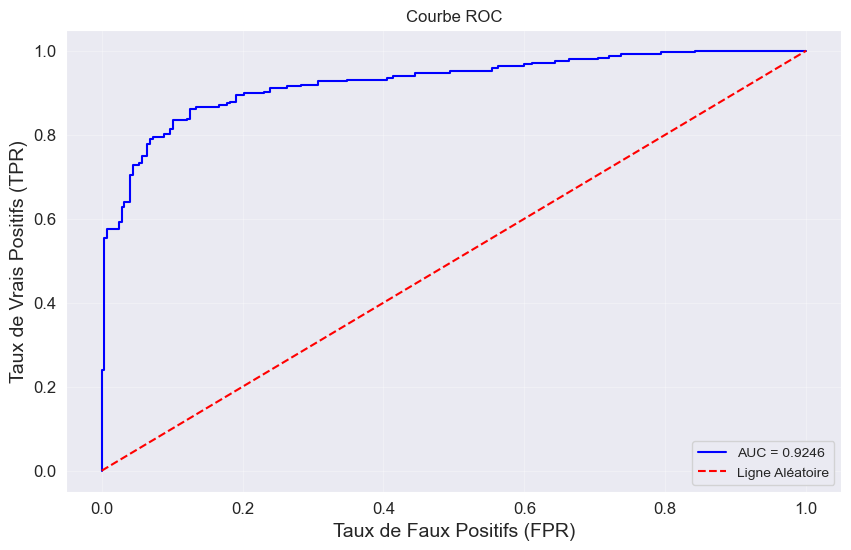


Validation croisée :
Précision moyenne (5 plis) : 0.9702 ± 0.0470


In [111]:
# Entraînement avec les meilleurs hyperparamètres
rand_clf = RandomForestClassifier(criterion = 'gini', max_depth = 13, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100,class_weight='balanced')

# Utilisation des données sur-échantillonnées par SMOTE
rand_clf.fit(X_resampled, y_resampled)

# Évaluation sur les données sur-échantillonnées (pour vérifier l'ajustement)
train_accuracy = accuracy_score(y_resampled, rand_clf.predict(X_resampled))
print(f"Précision sur les données sur-échantillonnées (entraînement) : {train_accuracy:.4f}")

# Prédiction et évaluation sur le jeu de test
y_pred_rand = rand_clf.predict(X_resampled_test)
y_pred_prob = rand_clf.predict_proba(X_resampled_test)[:, 1]  # Probabilités pour la classe positive

# Précision sur les données de test
test_accuracy = accuracy_score(y_resampled_test, y_pred_rand)
print(f"Précision sur les données de test : {test_accuracy:.4f}")

# Rapport de classification
print("\nRapport métriques de performance :")
print(classification_report(y_resampled_test, y_pred_rand))

# Calcul du F1-score, précision, rappel, AUC-ROC
f1 = classification_report(y_resampled_test, y_pred_rand, output_dict=True)['weighted avg']['f1-score']
roc_auc = roc_auc_score(y_resampled_test, y_pred_prob)

print(f"F1-score pondéré : {f1:.4f}")
print(f"AUC-ROC : {roc_auc:.4f}")

# Tracer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_resampled_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label="Ligne Aléatoire")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Validation croisée pour robustesse
cross_val_scores = cross_val_score(rand_clf, X_resampled, y_resampled, cv=5, scoring='accuracy')
print("\nValidation croisée :")
print(f"Précision moyenne (5 plis) : {cross_val_scores.mean():.4f} ± {cross_val_scores.std():.4f}")

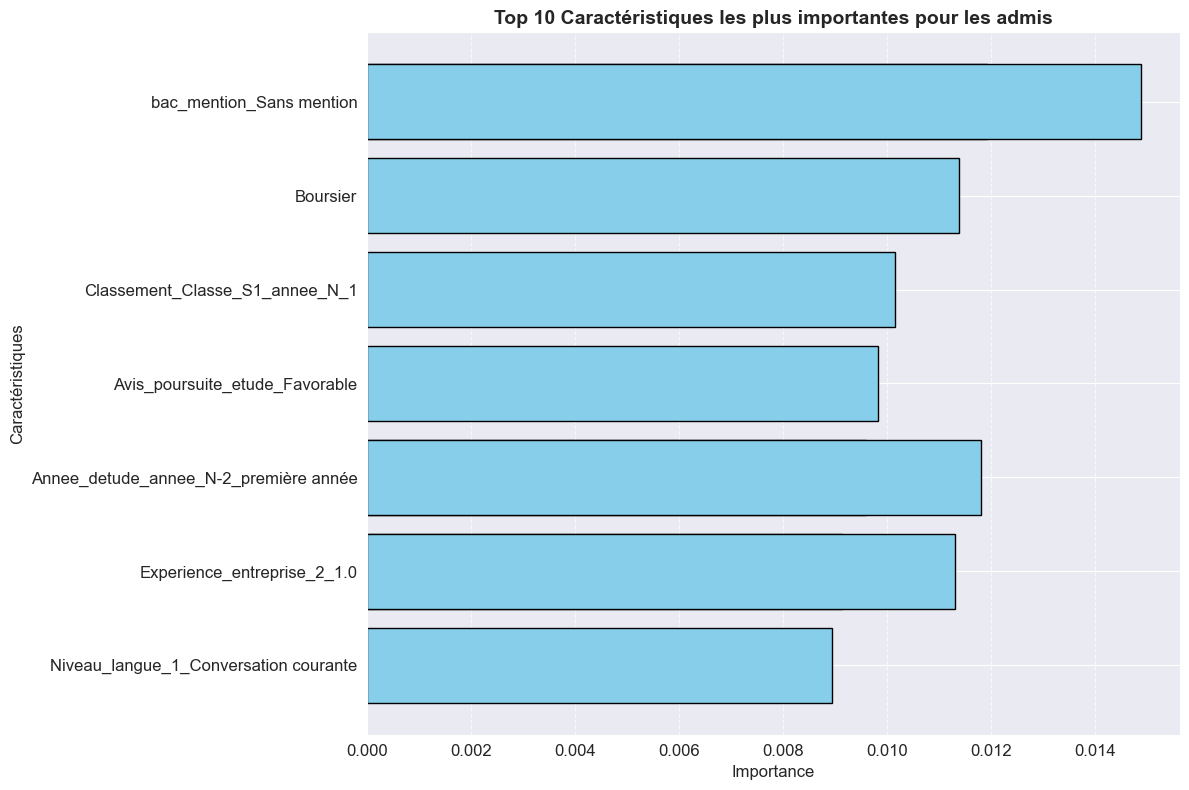


Top 10 Caractéristiques importantes pour les admis :
bac_mention_Sans mention: 0.0149
bac_mention_Sans mention: 0.0119
Annee_detude_annee_N-2_première année: 0.0118
Boursier: 0.0114
Experience_entreprise_2_1.0: 0.0113
Classement_Classe_S1_annee_N_1: 0.0101
Avis_poursuite_etude_Favorable: 0.0098
Annee_detude_annee_N-2_première année: 0.0096
Experience_entreprise_2_1.0: 0.0091
Niveau_langue_1_Conversation courante: 0.0089


In [112]:
# Analyse des importances des caractéristiques
if hasattr(rand_clf, 'feature_importances_'):
    importances = rand_clf.feature_importances_
    feature_names = X_resampled.columns
    sorted_indices = np.argsort(importances)[::-1]

# Limitez aux 10 caractéristiques les plus importantes pour un affichage plus clair
    top_features = 10
    top_indices = sorted_indices[:top_features]
    top_importances = importances[top_indices]
    top_feature_names = [feature_names[i] for i in top_indices]

    # Afficher les caractéristiques les plus importantes avec un graphique amélioré
    plt.figure(figsize=(12, 8))
    plt.barh(top_feature_names[::-1], top_importances[::-1], color="skyblue", edgecolor="black")
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Caractéristiques", fontsize=12)
    plt.title("Top 10 Caractéristiques les plus importantes pour les admis", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.show()

    # Liste des caractéristiques importantes
    print("\nTop 10 Caractéristiques importantes pour les admis :")
    for name, importance in zip(top_feature_names, top_importances):
        print(f"{name}: {importance:.4f}")